# Group Assignment 2.7: Extreme Value Analysis

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Extreme Value Analysis, Week 2.7, Friday, Jan 10, 2024.*

In this project, you will work on the uncertainty of precipitation in Turís, close to Valencia (Spain), where the past month of October an extreme flood occurred. Turís was the location where the highest rainfall was recorded. You have daily observations since 1999. The dataset was retrieved from the Ministry of Agriculture [here](https://servicio.mapa.gob.es/websiar/SeleccionParametrosMap.aspx?dst=1).

**The goal of this project is:**
1. Perform Extreme Value Analysis using Yearly Maxima and GEV.
2. Perform Extreme Value Analysis using POT and GPD.
3. Compare the results from both methods in terms of design return levels.

_Read the instructions for this project in `README.md` before beginning the analysis._

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats 
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 14})

## Task 1: Import and Explore Data

The first step in the analysis is importing and exploring the data set.

The dataset has two columns: the first one provides the time stamp of the measurements and the last column shows the measured precipitation (mm). We set the first column as a datetime as they are the dates of the measurements.

In [4]:
# Import
P = pd.read_csv('turis.csv', delimiter = ',', parse_dates = True)
P.columns=['Date', 'Prec'] #rename columns
P['Date'] = pd.to_datetime(P['Date'], format='mixed')
P = P.sort_values(by='Date')

P.head()

,Date,Prec
0,1999-01-11,0.0
30,1999-01-12,0.0
1,1999-02-11,0.0
31,1999-02-12,0.0
2,1999-03-11,0.0


In [5]:
# values for markdown report
print(f"{P['Prec'].size:d}",
      f"{P['Prec'].min():.3f}",
      f"{P['Prec'].max():.3f}",
      f"{P['Prec'].mean():.3f}",
      f"{P['Prec'].std():.3f}",
      f"{P['Prec'].isna().sum():d}",
      f"{sum(P['Prec']==0):d}",
      sep=' | ')

8382 | 0.000 | 771.000 | 1.296 | 10.597 | 0 | 6644


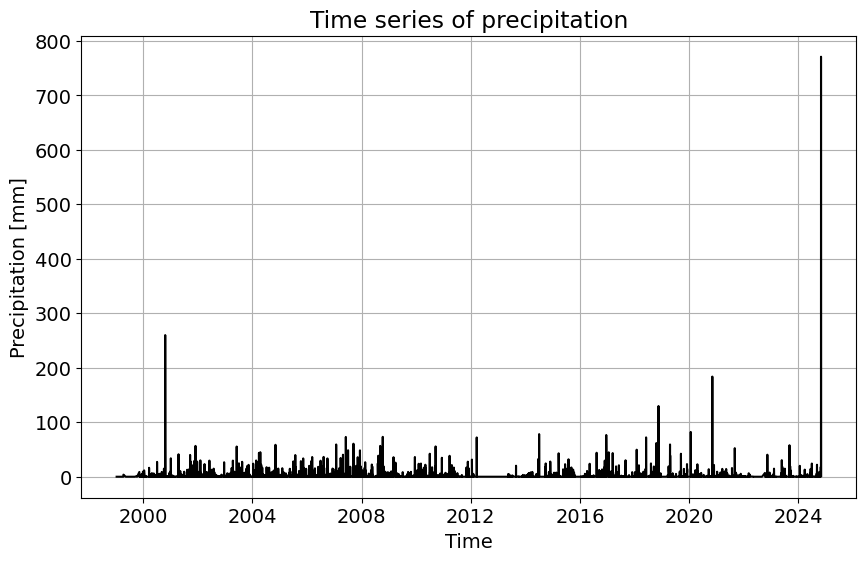

In [6]:
#Solution
plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()
plt.title('Time series of precipitation');

## Task 2: Yearly Maxima & GEV

Let's start with the first EVA analysis!

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1:</b>   
Sample the data set by finding the yearly maxima and add the sampled extremes to your time series plot as red dots.
</p>
</div>

The shape of the sampled extremes is: (26, 2)


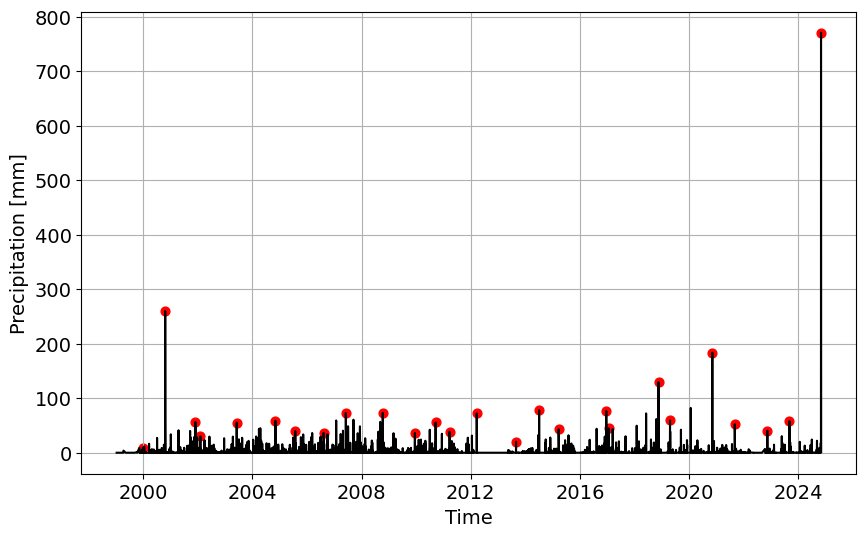

In [7]:
# Solution:
idx_max = P.groupby(pd.DatetimeIndex(P['Date']).year)['Prec'].idxmax()
YM = P.loc[idx_max]
print('The shape of the sampled extremes is:', YM.shape)

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(YM['Date'], YM['Prec'], 40, 'r')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2:</b>   Compute the empirical cumulative distribution function of the sampled maxima. Fit the appropriate extreme value distribution function using <code>scipy.stats</code> and assess the fit via an exceedance plot with semi-log scale.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><b>Tip:</b> save the parameters of an instance of <code>rv_continuous</code> as a tuple to make it easier to use the methods of the distribution later.
<br><br>For example, define parameters like this:
<br><code>params = ... .fit( ... )</code>
<br>instead of like this:
<br><code>param1, param2, param3 = ... .fit( ... )</code>
<br>(see WS15 solution for examples).
</p></div>

GEV parameters are: -0.426, 45.317, 29.848


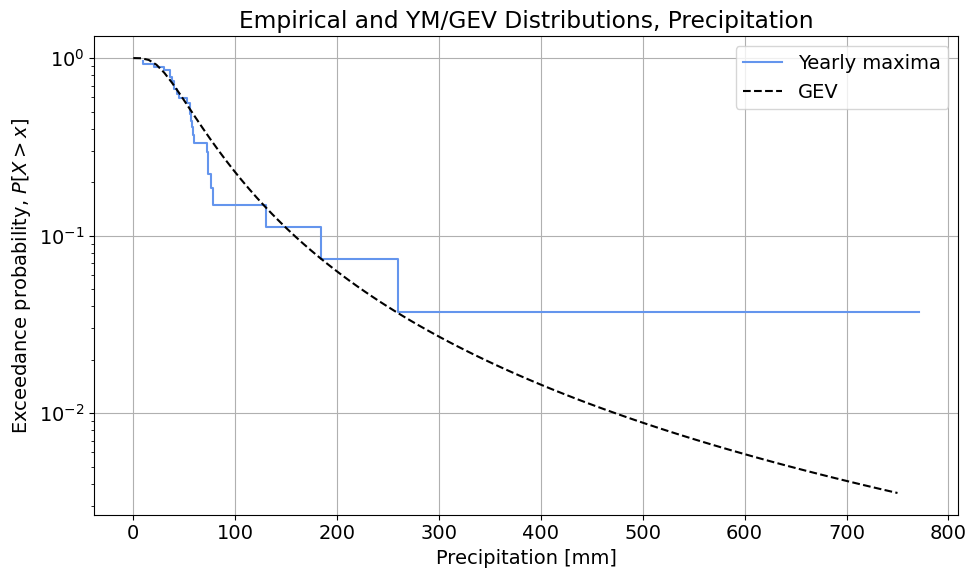

In [8]:
#Function for the ECDF
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n + 1)/(n + 1)
    return [y, x]

#Fit the parametric distribution to the extreme observations
params_YM = stats.genextreme.fit(YM['Prec'])
print('GEV parameters are: {:.3f}, {:.3f}, {:.3f}'.format(*params_YM))

#Compare both the empirical and parametric distributions in semilog scale

x_range = np.linspace(0, 750, 100)
plt.figure(figsize=(10, 6))
plt.step(ecdf(YM['Prec'])[1],
         1 - ecdf(YM['Prec'])[0],
         'cornflowerblue',
         label = 'Yearly maxima')
plt.plot(x_range,
         1 - stats.genextreme.cdf(x_range, *params_YM),
         '--k', label='GEV')
if params_YM[0]>0:
    bound = params_YM[1] - params_YM[2]/(-params_YM[0])
    plt.axvline(x = bound, color = 'red',
                linestyle = ':',
                label='Bound')
plt.xlabel('Precipitation [mm]')
plt.ylabel('Exceedance probability, $P[X > x]$')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Empirical and YM/GEV Distributions, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/gev_rain.svg');

In [9]:
# for Markdown report
print('GEV parameters are: {0:.3f} | {3:.3f} | {1:.3f} | {2:.3f}\n'.format(*params_YM, -params_YM[0]))

if params_YM[0]>0:
    bound = params_YM[1] - params_YM[2]/(-params_YM[0])
    print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - scipy.stats shape greater than 0\n'
          '  - MUDE book shape less than 0\n'
          '  - Tail type is Reverse Weibull --> there is a bound!\n'
          '  - bound = '
          f'{params_YM[1]:.3f} - {params_YM[2]:.3f}/(-{params_YM[0]:.3f}) = {bound:.3f}')
elif params_YM[0]<0:
    print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - scipy.stats shape less than 0\n'
          '  - MUDE book shape greater than 0\n'
          '  - Tail type is Frechet --> unbounded\n')
else:
     print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - Tail type is Gumbel\n')

GEV parameters are: -0.426 | 0.426 | 45.317 | 29.848

Shape parameter from scipy.stats is -0.426
  - scipy.stats shape less than 0
  - MUDE book shape greater than 0
  - Tail type is Frechet --> unbounded



## Task 3: POT and GPD

Let's go for Peak Over Threshold (POT)---make sure you **read** this section carefully, as there are some important tips for implementing the method correctly!

As described in the book: _when performing EVA with POT, we model **excesses** over the threshold, not the actual value of the extreme event._ In principle, this can simply be described as follows:

$$
X = th + E
$$

where $X$ is the random variable of interest (rain, in this case), $th$ is the threshold and $E$ is the _excess_ (also a random variable). In other words, the distribution-fitting part of our EVA is performed on $E$. However, it is not practical to verify/validate or make inference with our distribution on the random variable $E$ for two key reasons:
1. It is more convenient to think in terms of $X$, and
2. We often need to calibrate the threshold value, which produces countless different sets of sampled extremes, distributions and random variables, $E$, which cannot be compared easily.

As such, we continue to perform our analysis in terms of $X$, while making sure to address the fact that our POT data and distributions are defined in terms of $E$. In practical terms, this means we need to <em>add and subtract the threshold value at certain points in the analysis.</em>

Note: with the exception of the check on the Poisson distribution, as done in the book and bonus, below, the threshold and declustering time evaluation is outside the scope of MUDE.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 3.1:</b>   
Apply POT on the timeseries using a declustering time of 48 hours and a threshold of 40mm. Plot the sampled extremes on the timeseries as blue dots.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">Hint: you can use the function <code>find_peaks</code> from Scipy, as done in PA15.</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    the code below to find the peaks is very similar to PA15. In this task it is not necessary to add or subtract the threshold as we are focused only on collecting the observations of the random variable (arbitrarily defined as $X$ in the explanation above).
</div>
</div>

The shape of the sampled extremes is: (38,)


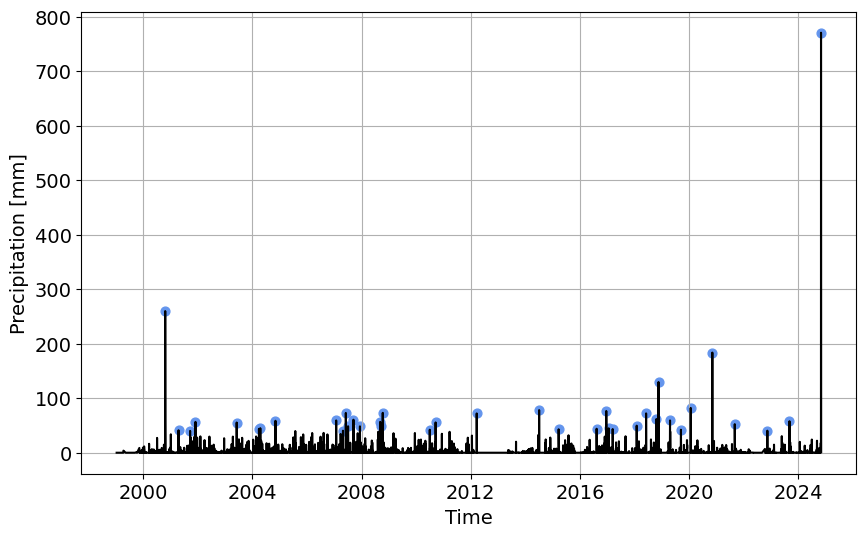

In [10]:

# Solution:
threshold = 40

distance = 2 #days
peaks, _ = find_peaks(P['Prec'], height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape)

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(P.iloc[peaks, 0], P.iloc[peaks, 1], 40, 'cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.2:</b>   Compute the empirical cumulative distribution function of the sampled maxima. Fit the appropriate extreme value distribution function using <code>scipy.stats</code> and assess the fit via an exceedance plot with semi-log scale.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">Hint: you need to fit a GPD with a location parameter of 0 on the excesses. You can force the fitting of a distribution with a given value of the parameters using the keyword argument <code>floc</code>.</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    in this task the threshold is subtracted from the data in the argument of the GPD fitting method (thus fitting the distribution to the excesses). In preparing the plot, note the difference between the way the empirical and theoretical CDF are used: the empirical uses the random variable values directly (the DataFrame column at index 1), whereas the GPD "adds the threshold back in" for the random variable value, and uses the excess value as the argument for the CDF.
</div>
</div>

GPD parameters are: 0.714, 0.000, 14.027


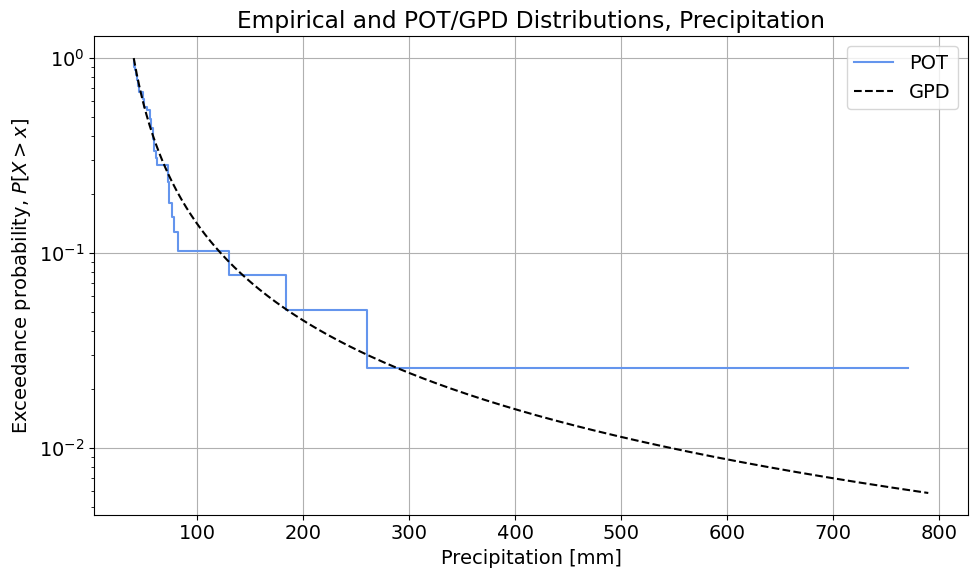

In [11]:
params_POT = stats.genpareto.fit(P.iloc[peaks, 1] - threshold, floc=0)
print('GPD parameters are: {:.3f}, {:.3f}, {:.3f}'.format(*params_POT))

excess_range = np.linspace(0, 750, 500)
plt.figure(figsize=(10, 6))
plt.step(ecdf(P.iloc[peaks, 1])[1],
         1 - ecdf(P.iloc[peaks, 1])[0],
         'cornflowerblue', label = 'POT')
plt.plot(excess_range + threshold,
         1 - stats.genpareto.cdf(excess_range, *params_POT),
         '--k', label='GPD')
if params_POT[0]<0:
    bound_POT = threshold - params_POT[2]/params_POT[0]
    print(f'Bound exists at {bound_POT:.3f}')
    plt.axvline(x = bound_POT, color = 'red',
                linestyle = ':',
                label='Bound')
plt.xlabel('Precipitation [mm]')
plt.ylabel('Exceedance probability, $P[X > x]$')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Empirical and POT/GPD Distributions, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/gpd_rain.svg');

In [14]:
# for Markdown report
print('GPD parameters are: {0:.3f} | {1:.3f} | {2:.3f}\n'.format(*params_POT, params_POT[0]))

if params_POT[0]>0:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - scipy.stats and MUDE book shape greater than 0\n'
          '  - Tail type --> heavy; power function behavior\n')
elif params_POT[0]==-1:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - Tail type is Exponential\n')
elif params_POT[0]<0:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - scipy.stats and MUDE book shape less than 0\n'
          '  - Tail type --> bounded\n'
          '  - bound = '
          f'{threshold:.3f} - {params_POT[2]:.3f}/({params_POT[0]:.3f}) = {bound_POT:.3f}')
else:
     print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - Tail type is Gumbel\n')

GPD parameters are: 0.714 | 0.000 | 14.027

Shape parameter from scipy.stats is 0.714
  - scipy.stats and MUDE book shape greater than 0
  - Tail type --> heavy; power function behavior



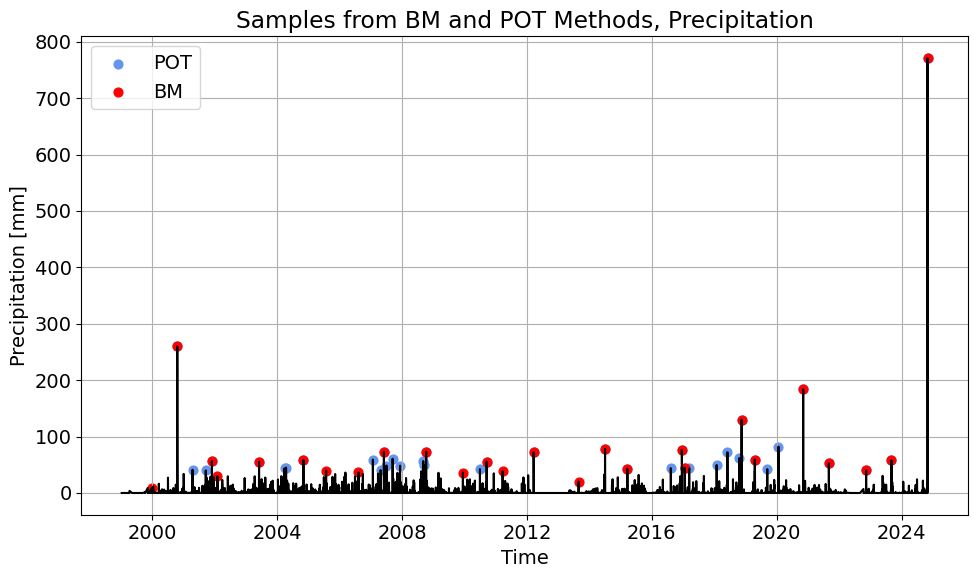

In [15]:
# Time series plot with both sets of extremes
# For Report_solution.md

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(P.iloc[peaks, 0], P.iloc[peaks, 1],
            40, 'cornflowerblue', label='POT')
plt.scatter(YM['Date'], YM['Prec'],
            40, 'r', label='BM')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()
plt.legend()
plt.title('Samples from BM and POT Methods, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/extremes_rain.png');

## Task 4: Computing Return Levels

In this section, we are going to use the distributions found in the previous two Tasks to compute design return levels and compare the results that both EVA methods provide.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4.1:</b>   Assuming that we want to design our structure to survive a loading situation with a return period RT = 100 years, what are the design values predicted by both EVA approaches?
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Remember you can use tuple unpacking as an argument for methods of <code>scipy.stats.rv_continuous</code>, like this: <code>*params</code> (see WS15 solution for examples).</p></div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    here, again, note the addition of the threshold to the output of the inverse CDF method (<code>ppf</code>), thus "converting" the excess back to the original random variable.
</div>
</div>

In [20]:
# # YM & GEV
# YM_design_value = YOUR_CODE_HERE

# # POT & GPD
# average_n_excesses = YOUR_CODE_HERE
# non_exc_prob = YOUR_CODE_HERE
# POT_design_value = YOUR_CODE_HERE

# Solution:
# YM & GEV
YM_design_value = stats.genextreme.ppf(1 - 1/100, *params_YM)

# POT & GPD
average_n_excesses = len(peaks)/YM.shape[0]
non_exc_prob = 1 - 1/(100*average_n_excesses)
POT_design_value = stats.genpareto.ppf(non_exc_prob, *params_POT) + threshold

print('The design value for a RT = 100 years computed using',
      'BM and GEV is:', np.round(YM_design_value, 3), 'mm')
print('The design value for a RT = 100 years computed using',
      'POT and GPD is:', np.round(POT_design_value, 3), 'mm')

The design value for a RT = 100 years computed using BM and GEV is: 472.684 mm
The design value for a RT = 100 years computed using POT and GPD is: 710.541 mm


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4.2:</b> create the return level plot for both EVA approaches (values of the random variable in the x-axis and return period on the y-axis; the y-axis in log scale). Consider return periods up to at least 500 years.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    the threshold is also added here, in an identical way as in Task 4.1.
</div>
</div>

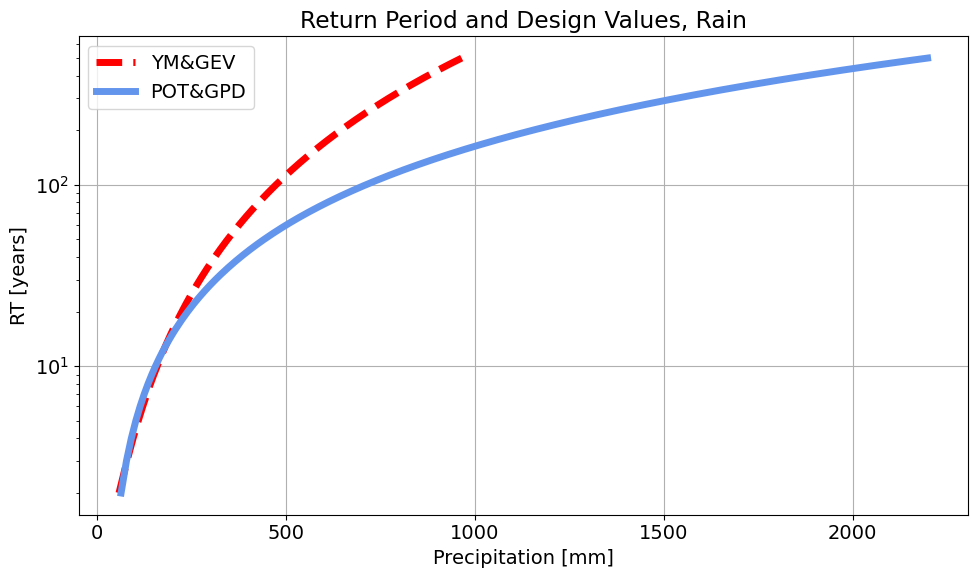

In [22]:
RT_range = np.linspace(1, 500, 500)

# YOUR_CODE_HERE (more than one line!)

# plt.figure(figsize=(10, 6))
# plt.plot(YM_range, RT_range, 'r', label = 'YM&GEV')
# plt.plot(POT_range, RT_range, 'cornflowerblue', label = 'POT&GPD')
# YOUR_FIGURE_FORMATTING_CODE_HERE (more than one line!)

# Solution:
#range of RT
RT_range = np.linspace(2, 500, 500)

#YM&GEV
YM_range = stats.genextreme.ppf(1 - 1/RT_range, *params_YM)

#POT&GPD
average_n_excesses = len(peaks)/YM.shape[0]
non_exc_prob_range = 1 - 1/(RT_range*average_n_excesses)
POT_range = stats.genpareto.ppf(non_exc_prob_range, *params_POT) + threshold

plt.figure(figsize=(10, 6))
plt.plot(YM_range, RT_range, '--r', label = 'YM&GEV', linewidth=5)
plt.plot(POT_range, RT_range, 'cornflowerblue', label = 'POT&GPD', linewidth=5)
if params_YM[0]>0:
    bound_YM = params_YM[1] - params_YM[2]/(-params_YM[0])
    plt.axvline(x = bound_YM, color = 'black',
                linestyle = ':',
                label='Bound, YM',
                linewidth=3)
if params_POT[0]<0:
    bound_POT = threshold - params_POT[2]/params_POT[0]
    print(f'Bound exists at {bound_POT:.3f}')
    plt.axvline(x = bound_POT, color = 'black',
                linestyle = ':',
                label='Bound, POT',
                linewidth=3)
plt.xlabel('Precipitation [mm]')
plt.ylabel('RT [years]')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Return Period and Design Values, Rain')
plt.tight_layout()
# plt.savefig('./figures_solution/design_rain.svg');

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Note:</b> At this point you will be able to answer all of the required questions in the Report. You are encouraged to add additional cells to make computations to further justify you explanations (e.g., to generate values for Markdown tables, or calculate a few more return levels, etc.).
</p>
</div>

## Task 5 (optional): Influence of POT Parameters

_This part is worth 2 extra credit points!_

When deciding whether your POT distribution is suitable as a model for use in design, it is useful to analyze whether the selected parameters to perform the POT analysis (threshold and declustering time) are appropriate, in terms of the underlying assumptions of a Poisson distribution. Refer to Chapter 7.3 of the book, on page "Parameters selection" and apply the analysis presented there to your POT results. You can also apply a $\chi^2$ (chi-squared) hypothesis test, as we did earlier in Q1. Perform the calculations in cells here, and include the following in your `Report.md`.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 5 (optional):</b>
    
There are three ways to do this, all of which use as "data" the _excesses_; the number of extremes sampled (observed) per year given our choice of threshold and declustering time:
    
<ol>
    <li>Compute and compare the mean and variance.</li>
    <li>Fit a Poisson distribution to the number of excesses and compare theoretical and empirical distributions (see plot in book).</li>
    <li>Use a $\chi^2$ (chi-squared) hypothesis test for the mean number of excesses per year.</li>
</ol>

The $\chi^2$ value is found by taking the sum of the squared differences between the probability mass function (PMF) of the <em>observed</em> excesses and the PMF of the <em>predicted</em> excess, divided by the latter.
    
$$
\chi^2 = \sum \frac{\bigl(p_O(o_i) - p_E(e_i)\bigr)^2}{p_E(e_i)}
$$
    
The degree of freedom is 1, and you can use a significance level of 0.05. The null hypothesis is: observations (number of excesses) come from a Poisson distribution.
    
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Hint: while our primary objective in EVA is evaluating the distribution of the random variable $X$, the number of excesses observed in a given period (regardless of BM or POT) is also a random variable, which in the case of POT can be described using the Poisson distribution.
    
Recall that the Poisson distribution is a <em>discrete probability distribution,</em> which is defined using a <em>probability mass function</em> (PMF) instead of a PDF. The PMF can be described using notation $p_X(X=x)$, which produces the probability of observing the discrete value $x$ of random variable $X$. The implementation in Python is slightly different, inheriting methods from the parent class <code>rv_discrete</code> instead of <code>rv_continuous</code>.</p></div>

In [12]:
# YOUR_CODE_HERE

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution (bonus, part 1):</b>
    here we create a new DataFrame with peaks and dates that <em>counts the number of excesses observed in each year of the data set.</em> Then the mean and variance are compared to see if they are equal (which would be expected for a Poisson distribution).
    
<br><em>See report solution for explanation.</em>
</div>
</div>

In [23]:
peaks_year = P.loc[peaks]
count = peaks_year.groupby(pd.DatetimeIndex(peaks_year['Date']).year)['Prec'].count()
mean_count = count.mean()
var_count = count.var()
print(f'Mean = {mean_count:.3f} and variance = {var_count:.3f}')

Mean = 2.000 and variance = 1.778


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution (bonus, part 2 and 3):</b>
    here we use the DataFrame from the previous part to: find the range (min and max) of observed exceedences observed in each year of the data set; find the probability that the mean number of exceedances is observed, given a Poisson distribution;  compute the chi-squared test; plot the empirical and theoretical PMF for comparison.
    
<br>For convenience a second DataFrame is created to collect the number of excesses and counts for each year together in the same object. Since it is used for both parts 2 and 3 of the bonus, both solutions are presented together.
    
<em>See report solution for explanation.</em>
</div>
</div>

Accept the null hypothesis:
   Poisson distribution can represent the excesses!


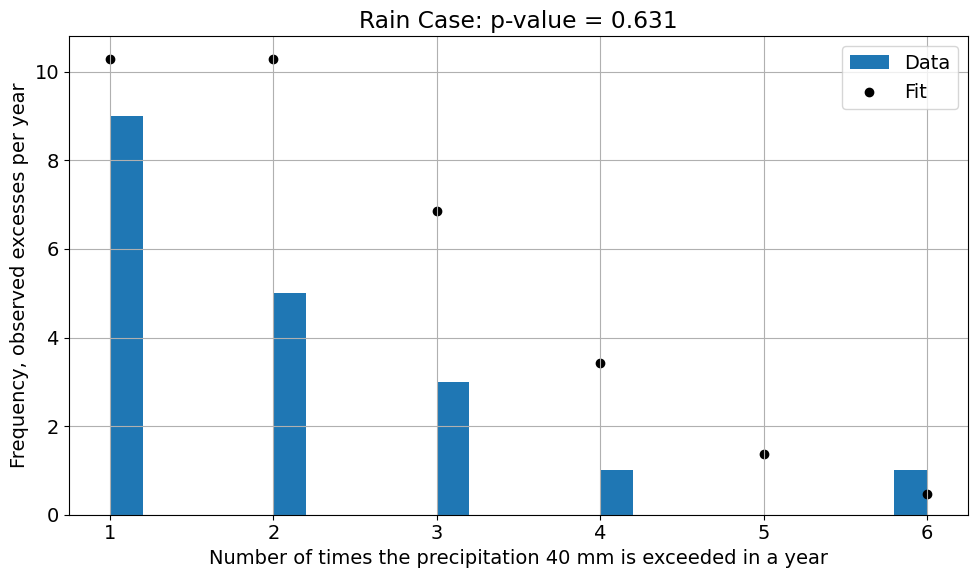

In [24]:
import math

k = np.arange(count.min(), count.max()+1,1)
PMF_calc = stats.poisson.pmf(k, mean_count)
occur = count.groupby(count).size()
occur = pd.DataFrame(occur, columns=['Prec'])

occur_df = pd.DataFrame(index=k, columns=['Count'])
occur_df = occur_df.join(occur)
occur_df = occur_df['Prec'].fillna(0)

PMF_data = occur_df.values/len(peaks_year)
chi = np.sum((PMF_data - PMF_calc)**2/PMF_calc)
p_value = 1 - stats.chi2.cdf(x=chi, df=1)
if p_value > 0.05:
    print('Accept the null hypothesis:\n',
          '  Poisson distribution can represent the excesses!')
else:
    print('Reject the null hypothesis:\n',
          '  Poisson distribution does NOT represent the excesses!')

plt.figure(figsize=(10, 6))
plt.hist(count, bins=25, label='Data', density=False)
plt.scatter(k, PMF_calc*len(peaks_year), label='Fit', color = 'k')
plt.legend()
plt.grid()
plt.title(f'Rain Case: p-value = {p_value:.3f}')
plt.ylabel('Frequency, observed excesses per year')
plt.xlabel('Number of times the precipitation '
           + f'{threshold} mm is exceeded in a year')
plt.tight_layout()
# plt.savefig('./figures_solution/bonus_rain.svg');

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.